Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [2]:
data = pd.read_csv("C:/ML_projects/forestfire/merged_data_2021_12.csv")

create target variable 'zone_risk' from 'confidence'

In [3]:
data['zone_risk'] = data['confidence'].map({
    'l': 'Low',
    'n': 'Medium',
    'h': 'High'
})
data['zone_risk'] = pd.Categorical(data['zone_risk'], categories=["Low", "Medium", "High"])

Modification / feature engineering

In [4]:
features = [
    "bright_ti4", "bright_ti5", "scan", "track", "frp",
    "precipitation", "air_temp", "humidity", "wind_speed",
    "solar_radiation", "type", "lat", "lon", "zone_risk"
]

data_model = data[features].copy()

# Step 4: Custom Feature Engineering
data_model['temp_humid'] = data_model['air_temp'] * data_model['humidity']
data_model['wind_frp'] = data_model['wind_speed'] * data_model['frp']
data_model['heat_intensity'] = data_model['bright_ti4'] + data_model['bright_ti5'] + data_model['frp']
data_model['dry_index'] = data_model['air_temp'] / (data_model['humidity'] + 1)
data_model['solar_precip'] = data_model['solar_radiation'] / (data_model['precipitation'] + 1)
data_model['interaction_1'] = data_model['air_temp'] * data_model['solar_radiation']
data_model['lat_abs'] = np.abs(data_model['lat'])

# Step 5: Encode Categorical 'type'
data_model['type'] = LabelEncoder().fit_transform(data_model['type'])

Split train-test

In [5]:
X = data_model.drop(columns=['zone_risk'])
y = data_model['zone_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train Multinomial Logistic Regression Model
X_train_const = sm.add_constant(X_train)
model = sm.MNLogit(y_train, X_train_const)
result = model.fit()

         Current function value: 0.209973
         Iterations: 35


c:\Users\Nishit Shelar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluation

In [8]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions
X_test_const = sm.add_constant(X_test)
y_pred = result.predict(X_test_const)

# Get predicted class index (0, 1, 2)
y_pred_class = y_pred.idxmax(axis=1)

# 🔁 Map numerical predictions back to original string labels
label_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
y_pred_labels = y_pred_class.map(label_mapping)

# ✅ Now we can safely evaluate
print(confusion_matrix(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))


[[  503     0     0]
 [    5   249   861]
 [    0   130 11363]]
              precision    recall  f1-score   support

        High       0.99      1.00      1.00       503
         Low       0.66      0.22      0.33      1115
      Medium       0.93      0.99      0.96     11493

    accuracy                           0.92     13111
   macro avg       0.86      0.74      0.76     13111
weighted avg       0.91      0.92      0.91     13111



Plot and visuals

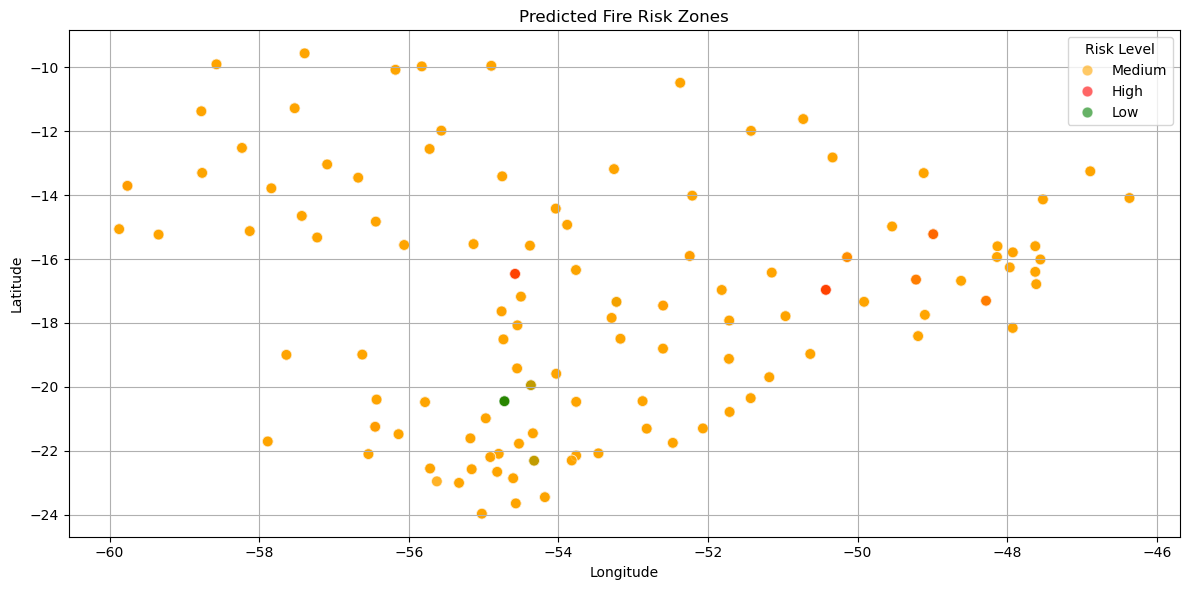

In [ ]:
pred_class = result.predict(sm.add_constant(X)).idxmax(axis=1)
label_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
data_model['predicted_risk'] = pred_class.map(label_mapping)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=data_model,
    x='lon', y='lat',
    hue='predicted_risk',
    palette={'Low': 'green', 'Medium': 'orange', 'High': 'red'},
    alpha=0.6, s=60
)
plt.title("Predicted Fire Risk Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Risk Level")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pickle

# Save the trained model
with open("multinomial_logit_model.pkl", "wb") as f:
    pickle.dump(result, f)
